In [1]:
import re
import json

In [3]:
with open('Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 21258

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
17      2929409        21258               30   
27      2655309        21258               30   
83      2422690        21258               65   
149     1878228        21258               65   
159     1790460        21258               65   

                                                 title  year  \
17   An initial investigation into the real-time co...  2016   
27        The use of technology in Suicide Prevention.  2015   
83   Social Attitude Towards A Conversational Chara...  2006   
149  Emotion recognition in non-structured utteranc...  2005   
159  You just do not understand me! Speech Recognit...  2014   

                                              abstract  
17   This paper presents early-stage results of our...  
27   Suicide is one of the leading causes of death ...  
83   This paper describes our experience with the d...  
149  The aim of our research is to provide robots t...  
159  Speech Recognition has not fully permeated in ...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

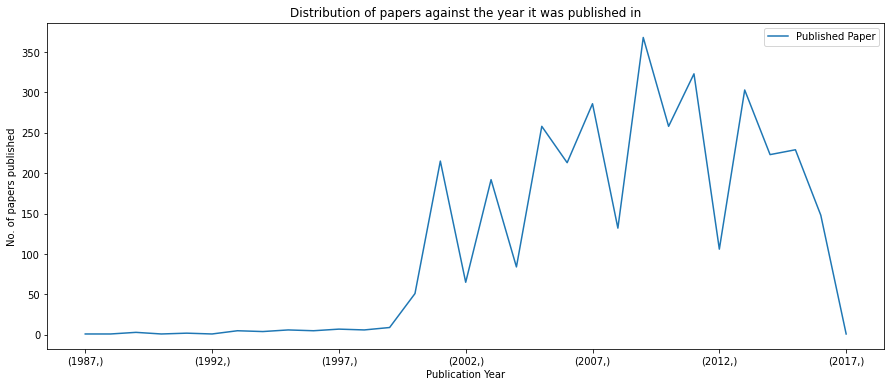

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2001 with year 2009 accounting for the highest number of papers with 368 papers

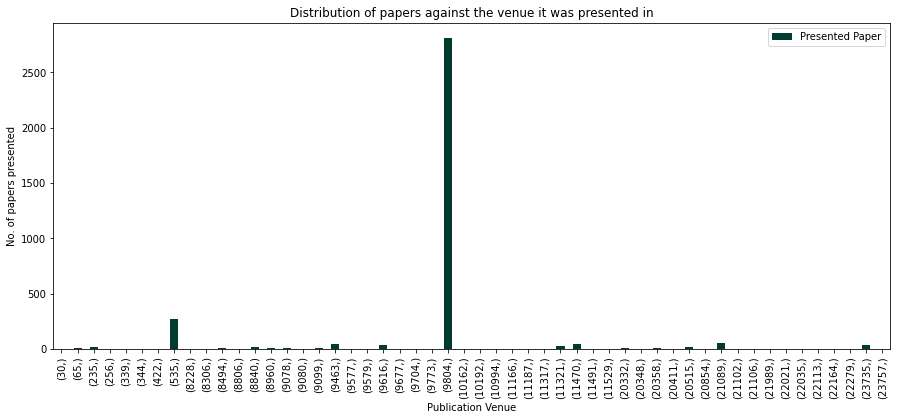

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [17]:
print(conference_data_dict[9804])
print(conference_data_dict[535])

conference of the international speech communication association
ieee automatic speech recognition and understanding workshop


One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 9804 which corresponds to the **Conference of the International Speech Communication Association**, Hence most of the papers in the community are from that conference. The second most presented venue in the community is from **IEEE Automatic Speech Recognition and Understanding Workshop**. Again, this conference seems quite similar to the first one. We can make an initial guess here that most of the papers will be related to speech and communication.

In [18]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

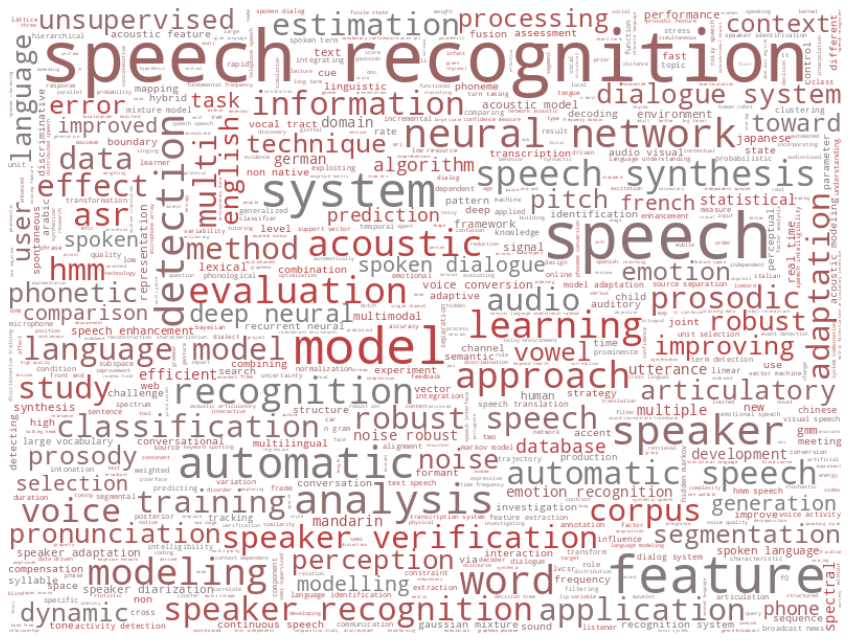

In [19]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, as expected, we see that a lot of papers of the community focus on speech and speaking. Since most papers of the community were presented at the most poular conferences were about Speech Recognition and Understanding, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

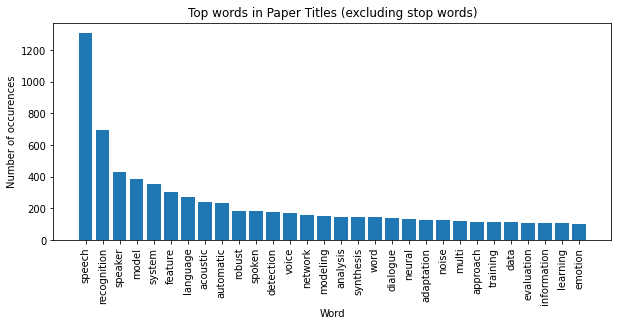

In [20]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are speech, recognition, speaker and so on. Considering most papers are about speeches and recognition, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [21]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [22]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [23]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [24]:
lda.show_topics(total_topics,6)

[(0,
  '0.028*"speech" + 0.014*"frequency" + 0.014*"speaker" + 0.011*"analysis" + 0.011*"recognition" + 0.011*"time"'),
 (1,
  '0.078*"speech" + 0.031*"recognition" + 0.018*"system" + 0.011*"feature" + 0.010*"model" + 0.009*"environment"'),
 (2,
  '0.032*"speech" + 0.026*"speaker" + 0.016*"recognition" + 0.013*"approach" + 0.009*"word" + 0.009*"verification"'),
 (3,
  '0.028*"speech" + 0.021*"speaker" + 0.020*"recognition" + 0.017*"voice" + 0.016*"spoken" + 0.016*"detection"'),
 (4,
  '0.035*"speech" + 0.026*"recognition" + 0.025*"speaker" + 0.021*"network" + 0.016*"neural" + 0.012*"language"'),
 (5,
  '0.058*"speech" + 0.034*"recognition" + 0.020*"system" + 0.019*"automatic" + 0.019*"model" + 0.017*"speaker"'),
 (6,
  '0.054*"speech" + 0.027*"recognition" + 0.024*"analysis" + 0.023*"feature" + 0.018*"model" + 0.015*"acoustic"'),
 (7,
  '0.035*"language" + 0.023*"speaker" + 0.022*"model" + 0.018*"speech" + 0.015*"identification" + 0.011*"corpus"'),
 (8,
  '0.020*"speech" + 0.016*"syste

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [25]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

speech  frequency   speaker  analysis  recognition      time    domain  \
0  0.028314   0.014434  0.013852  0.011121     0.010713  0.010660  0.010228   
1  0.077578   0.000000  0.007415  0.000000     0.030870  0.000000  0.000000   
2  0.031732   0.000000  0.026146  0.000000     0.015808  0.006044  0.000000   
3  0.027631   0.000000  0.021296  0.000000     0.020166  0.000000  0.000000   
4  0.035193   0.000000  0.025068  0.000000     0.025593  0.000000  0.000000   
5  0.058189   0.000000  0.017354  0.000000     0.034030  0.000000  0.000000   
6  0.053924   0.000000  0.014219  0.023999     0.026684  0.000000  0.000000   
7  0.017774   0.000000  0.022702  0.000000     0.010030  0.000000  0.000000   
8  0.019645   0.000000  0.005686  0.000000     0.011362  0.000000  0.006797   
9  0.055737   0.000000  0.005929  0.000000     0.027677  0.000000  0.000000   

   evaluation  tracking     model  ...  structure  classification  \
0    0.009683  0.008771  0.008567  ...   0.000000        0.000000   
1    0.000000  0.000000  0.009695  ...   0.000000        0.000000   
2    0.000000  0.000000  0.008066  ...   0.000000        0.000000   
3    0.000000  0.000000  0.013065  ...   0.000000        0.000000   
4    0.005811  0.000000  0.009079  ...   0.000000        0.000000   
5    0.005526  0.000000  0.018690  ...   0.000000        0.000000   
6    0.000000  0.000000  0.018113  ...   0.000000        0.000000   
7    0.000000  0.000000  0.022121  ...   0.000000        0.000000   
8    0.000000  0.000000  0.000000  ...   0.007354        0.007053   
9    0.000000  0.000000  0.016975  ...   0.000000        0.000000   

   conversation  pronunciation  application  knowledge   english       asr  \
0      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
1      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
2      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
3      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
4      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
5      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
6      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
7      0.000000       0.000000     0.000000   0.000000  0.000000  0.000000   
8      0.006964       0.006230     0.005798   0.005697  0.005556  0.000000   
9      0.000000       0.008113     0.000000   0.000000  0.000000  0.009201   

    phoneme  enhancement  
0  0.000000     0.000000  
1  0.000000     0.000000  
2  0.000000     0.000000  
3  0.000000     0.000000  
4  0.000000     0.000000  
5  0.000000     0.000000  
6  0.000000     0.000000  
7  0.000000     0.000000  
8  0.000000     0.000000  
9  0.008274     0.005744  

[10 rows x 114 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


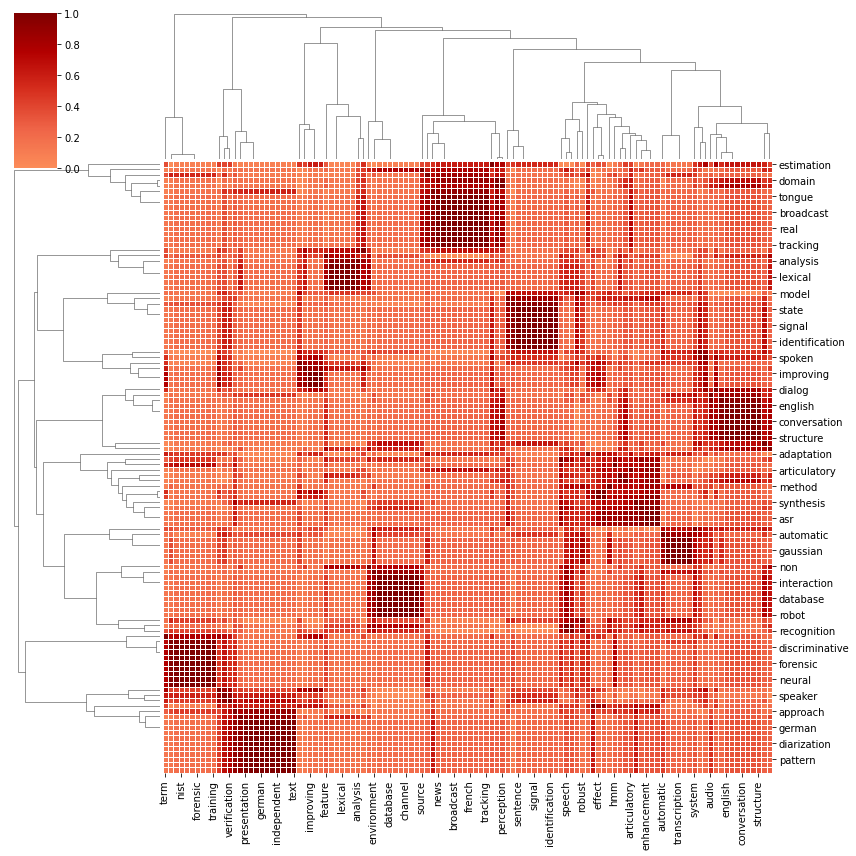

In [26]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [27]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  35.872776
3       0.648955  71.707100       2        1  11.099349
9      71.019684   9.971006       3        1   8.668368
6       3.785981  33.185135       4        1   8.545473
0     -42.666500  -9.222070       5        1   7.844082
7      -3.621689 -43.526516       6        1   7.138992
5      -3.632402  -4.171708       7        1   5.793672
8     -36.584400  35.804413       8        1   5.012972
2      44.391380  50.615383       9        1   5.012939
4      40.235809 -31.591665      10        1   5.011376, topic_info=            Term        Freq       Total Category  logprob  loglift
8         speech  180.000000  180.000000  Default  30.0000  30.0000
58       speaker   46.000000   46.000000  Default  29.0000  29.0000
24   recognition   84.000000   84.000000  Default  28.0000  28.0000
61      language   24.000000   24.000000  Default  27.0000  27.0000
193     acoustic   20.000000   20.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
135     approach    0.949361   12.832635  Topic10  -5.2207   0.3895
130   adaptation    0.896876   12.059652  Topic10  -5.2776   0.3948
245        noise    0.899598   16.366654  Topic10  -5.2746   0.0924
71     automatic    0.876767   26.169855  Topic10  -5.3003  -0.4027
219     spectral    0.764801    7.518662  Topic10  -5.4369   0.7079

[736 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
45        5  0.318069         '
45        6  0.318069         '
501       2  0.880750      2008
869       2  0.504124  accuracy
869       5  0.504124  accuracy
...     ...       ...       ...
126       3  0.194819      word
126       4  0.064940      word
126       6  0.064940      word
126       8  0.064940      word
126       9  0.129880      word

[845 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 10, 7, 1, 8, 6, 9, 3, 5])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [28]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [29]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [30]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  audible, murmur, nam, 2008, benchmark, southern, love, taiwan, non, dutch, mechanism, contraction, grounding, best, survey
Paper Titles:
Teleoperated or Autonomous?: How to Produce a Robot Operator's Pseudo Presence in HRI
Did you say a BLUE banana? The prosody of contrast and abnormality in Bulgarian and Dutch
Extreme reductions: Contraction of disyllables into monosyllables in Taiwan Mandarin
Improvements of the Philips 2000 Taiwan Mandarin Benchmark System

TOPIC 1:
Top Words:  preference, modality, smile, industrial, generate, automotive, almost, chat, semantics, module, flat, emovoice, concept, test, iris
Paper Titles:
Kettle hinders cat, shadow does not hinder shed: Activation of 'almost embedded' words in nonnative listening
Porting concepts from DNNs back to GMMs
Crowdsourcing Preference Tests, and How to Detect Cheating.
The use of technology in Suicide Prevention.

TOPIC 2:
Top Words:  system, dialogue, assistance, aspect, constructing, phenomenon, constr

## Analyzing the abstracts of the papers

In [31]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

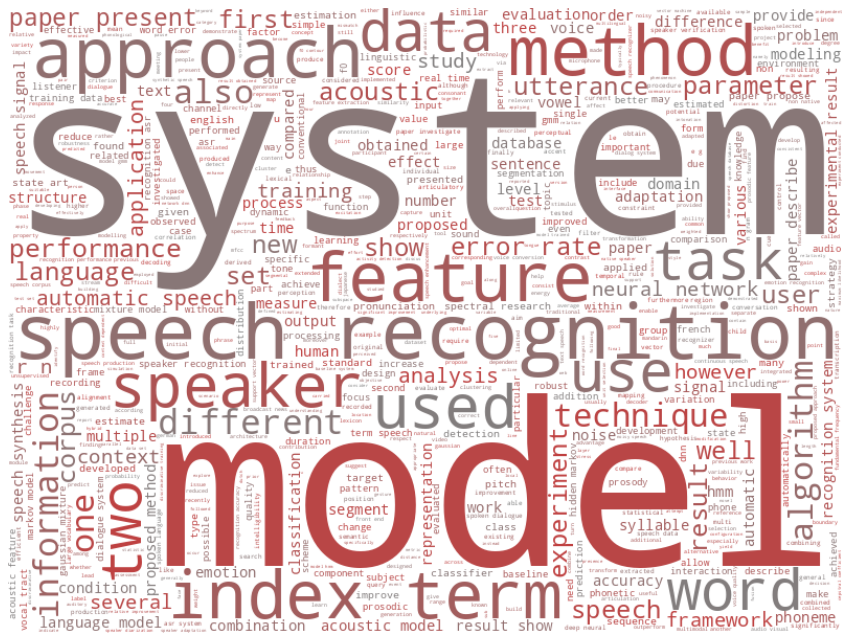

In [32]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [33]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [34]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [35]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [36]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [37]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [38]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [39]:
lda.show_topics(total_topics, 7)

[(0,
  '0.011*"system" + 0.006*"speech" + 0.005*"speech recognition" + 0.005*"model" + 0.005*"feature" + 0.005*"data" + 0.005*"approach"'),
 (1,
  '0.013*"system" + 0.012*"speech" + 0.008*"model" + 0.006*"speaker" + 0.005*"method" + 0.005*"approach" + 0.004*"index term"'),
 (2,
  '0.008*"speech" + 0.008*"model" + 0.008*"system" + 0.006*"task" + 0.005*"recognition" + 0.005*"speaker" + 0.004*"index term"'),
 (3,
  '0.014*"speech" + 0.008*"speaker" + 0.006*"feature" + 0.006*"method" + 0.006*"system" + 0.006*"language" + 0.005*"index term"'),
 (4,
  '0.014*"feature" + 0.009*"speech" + 0.005*"system" + 0.005*"approach" + 0.004*"word" + 0.004*"data" + 0.004*"language"'),
 (5,
  '0.012*"system" + 0.008*"speech" + 0.007*"method" + 0.006*"model" + 0.006*"speaker" + 0.005*"speech recognition" + 0.004*"index term"'),
 (6,
  '0.016*"model" + 0.011*"method" + 0.007*"system" + 0.006*"speech" + 0.006*"speech recognition" + 0.005*"feature" + 0.005*"use"'),
 (7,
  '0.011*"model" + 0.006*"system" + 0.00

In [40]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

system    speech  speech recognition     model   feature      data  \
0  0.010646  0.006263            0.005485  0.004908  0.004721  0.004602   
1  0.012930  0.012056            0.003301  0.008086  0.003585  0.003467   
2  0.008153  0.008261            0.003033  0.008228  0.003007  0.002966   
3  0.005956  0.014396            0.000000  0.003165  0.006480  0.002992   
4  0.005167  0.008652            0.003466  0.003389  0.013936  0.004020   
5  0.011928  0.008477            0.004721  0.005918  0.002483  0.004328   
6  0.007203  0.006401            0.006175  0.016084  0.004868  0.002942   
7  0.006423  0.005871            0.002562  0.010688  0.001954  0.003850   
8  0.009843  0.015559            0.001940  0.006811  0.004540  0.002215   
9  0.006159  0.010409            0.000000  0.008324  0.002610  0.006562   

   approach      task  performance  index term  ...  application    signal  \
0  0.004507  0.004206     0.003372    0.003332  ...     0.000000  0.000000   
1  0.004901  0.002257     0.000000    0.004323  ...     0.000000  0.000000   
2  0.003985  0.005614     0.002832    0.003991  ...     0.000000  0.000000   
3  0.002633  0.000000     0.003253    0.005208  ...     0.000000  0.000000   
4  0.004725  0.002204     0.003118    0.003360  ...     0.000000  0.000000   
5  0.004309  0.000000     0.000000    0.004442  ...     0.000000  0.000000   
6  0.002539  0.000000     0.003270    0.002981  ...     0.002912  0.002299   
7  0.000000  0.000000     0.000000    0.002743  ...     0.000000  0.003583   
8  0.000000  0.000000     0.000000    0.003490  ...     0.000000  0.000000   
9  0.003757  0.000000     0.003767    0.004443  ...     0.000000  0.002431   

    problem   process      also         1    human  speech signal      well  \
0  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.00000       0.000000  0.000000   
7  0.002211  0.002088  0.001960  0.000000  0.00000       0.000000  0.000000   
8  0.000000  0.000000  0.002745  0.002338  0.00193       0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.00000       0.002128  0.002122   

      vowel  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.000000  
6  0.000000  
7  0.000000  
8  0.000000  
9  0.002032  

[10 rows x 60 columns]

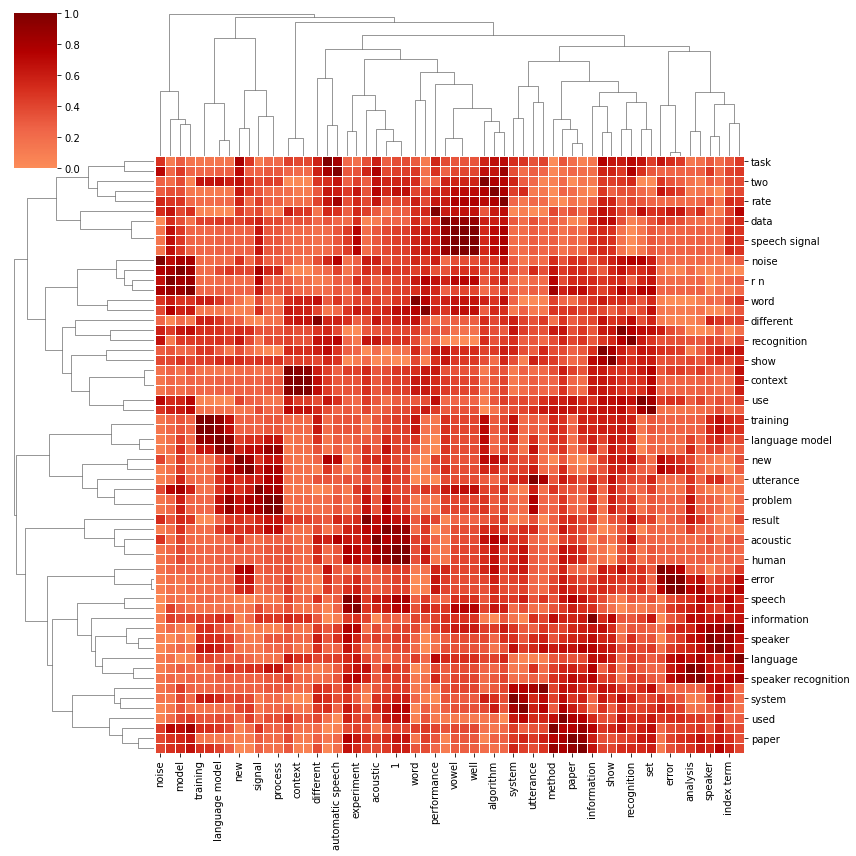

In [41]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [42]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  26.268592
2       0.648955  71.707100       2        1  13.182782
3      71.019684   9.971006       3        1  12.860685
9       3.785981  33.185135       4        1  12.081228
7     -42.666500  -9.222070       5        1   8.126868
0      -3.621689 -43.526516       6        1   6.694346
8      -3.632402  -4.171708       7        1   5.373426
1     -36.584400  35.804413       8        1   5.155946
6      44.391380  50.615383       9        1   5.128261
4      40.235809 -31.591665      10        1   5.127866, topic_info=                 Term       Freq      Total Category  logprob  loglift
157             model  24.000000  24.000000  Default  30.0000  30.0000
129            speech  33.000000  33.000000  Default  29.0000  29.0000
22            feature  14.000000  14.000000  Default  28.0000  28.0000
49             system  30.000000  30.000000  Default  27.0000  27.0000
264            method  16.000000  16.000000  Default  26.0000  26.0000
..                ...        ...        ...      ...      ...      ...
264            method   0.501119  16.686483  Topic10  -5.8823  -0.5350
46            speaker   0.480114  15.120732  Topic10  -5.9251  -0.4793
301              task   0.396064   8.427728  Topic10  -6.1175  -0.0872
498  automatic speech   0.343763   5.757005  Topic10  -6.2592   0.1523
209         utterance   0.341012   5.319208  Topic10  -6.2672   0.2233

[837 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
933       1  0.212579     1
933       2  0.212579     1
933       3  0.212579     1
933       4  0.212579     1
934       1  0.306000     2
...     ...       ...   ...
537       9  0.095887  word
537      10  0.095887  word
1020      1  0.276533  work
1020      2  0.276533  work
1020      3  0.276533  work

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 10, 8, 1, 9, 2, 7, 5])

In [43]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [44]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [48]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  podcastle, svarticulatory, interaction example, songle, dynamic net, motor equivalence, ucms, jp, lexico syntactic, 5ms, timit svarticulatory, data training word, training word model, improve word learning, speaker clustering system

Paper Titles:
PodCastle and songle: crowdsourcing-based web services for spoken content retrieval and active music listening
Uncontrolled Manifolds in Vowel Production: Assessment with a Biomechanical Model of the Tongue
Using temporal information for improving articulatory-acoustic feature classification
Unfolding speaker clustering potential: a biomimetic approach

****************************************************************************************************
TOPIC 1:
Top Words:  phenomenon implemented, 2016 911, article first appeared, first appeared, dx doi org, association via http, version article, via http, doi org, http dx doi, interspeech 2016 911, association via, appeared international speech, via http dx, first appeare

In [49]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [51]:
representative_df.to_csv("repr_21258.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
53149     1244105        21258             9099   
65352     2822801        21258             9804   
10261     2182616        21258              535   
53067     1907307        21258             9099   
39367     1977747        21258             8960   
...           ...          ...              ...   
10350     1286721        21258              535   
40712     2906891        21258             9078   
18352     1151681        21258             8228   
10284     1979387        21258              535   
282        943129        21258              235   

                                                   title  year  \
53149  PodCastle and songle: crowdsourcing-based web ...  2012   
65352  Uncontrolled Manifolds in Vowel Production: As...  2016   
10261  Using temporal information for improving artic...  2009   
53067  Unfolding speaker clustering potential: a biom...  2009   
39367  Static and Dynamic Error Propagation Networks ...  1988   
...                                                  ...   ...   
10350  Barge-in effects in Bayesian dialogue act reco...  2013   
40712  Machine listening techniques as a complement t...  2016   
18352  Same but different? — Using speech signal feat...  2012   
10284                 Dynamic network decoding revisited  2009   
282    Example-based speech intention understanding a...  2002   

                                                abstract  
53149  In this keynote talk, we describe two crowdsou...  
65352  Motor equivalence is a key feature of speech m...  
10261  This paper combines acoustic features with a h...  
53067  Speaker clustering is the task of grouping a s...  
39367  Error propagation nets have been shown to be a...  
...                                                  ...  
10350  Dialogue act recognition and simulation are tr...  
40712  Video is now one of the major sources of infor...  
18352  In this paper we demonstrate how speech signal...  
10284  We present a dynamic network decoder capable o...  
282    This paper proposes a method of speech intenti...  

[739 rows x 6 columns]